In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import numpy as np
import matplotlib.pyplot as plt
from pyfrechet.metric_spaces import MetricData, RiemannianManifold, CorrFrobenius
from geomstats.geometry.hypersphere import Hypersphere

from pyfrechet.metric_spaces.correlation.nearcorr import nearcorr
from tqdm import tqdm
from joblib import Parallel, delayed

INFO: Using numpy backend
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/fdasrsf/umap_metric.py:22: NumbaDeprecationWarning:The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/fdasrsf/umap_metric.py:54: NumbaDeprecationWarning:The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/pyt

# Correlation matrices

 /var/folders/zr/h_4389yx0t372wtwlt21sddw0000gn/T/ipykernel_69012/3647962942.py:56: RuntimeWarning:invalid value encountered in log10
 /var/folders/zr/h_4389yx0t372wtwlt21sddw0000gn/T/ipykernel_69012/3647962942.py:62: RuntimeWarning:divide by zero encountered in log10
 /var/folders/zr/h_4389yx0t372wtwlt21sddw0000gn/T/ipykernel_69012/3647962942.py:64: RuntimeWarning:divide by zero encountered in log10


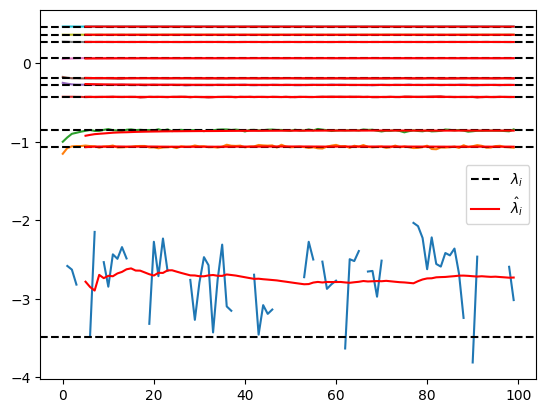

In [3]:
M = CorrFrobenius(10)

def add_noise(Mu, sig):
    d = Mu.shape[0]
    Z = np.random.normal(size=(d,d))/(M.dim**2)
    Z = Z + Z.T
    Z[np.diag_indices(d)] = np.random.normal(d)
    A = Mu + sig * Z
    return nearcorr(A, tol=[1e-8,1e-8])

def rand_corr(dim):
    S = np.random.randn(dim*dim).reshape((dim,dim))
    A = S.dot(np.random.randn(dim * (dim*dim*dim)).reshape((dim, dim*dim*dim)))
    return np.corrcoef(A)

def m(x, theta, mu):
    return M._frechet_mean(np.array([x, mu]), np.array([theta, 1-theta]))


def sim(x0, N, theta, sig, mu):
    x = np.zeros((N,M.dim,M.dim)) + x0
    for t in range(1,N):
        x[t,:,:] = add_noise(m(x[t-1,:], theta, mu), sig)
    return x


# look into generating random correlation or covariance matrices


N = 100
# mu = (1+np.arange(M.dim))*np.eye(M.dim, M.dim)/(1 + M.dim)
mu = rand_corr(M.dim)

# mu = np.array([
#     [    1, -0.5,    0],
#     [ -0.5,    1, -0.5],
#     [    0, -0.5,    1]
# ])
x0 = add_noise(mu, 1)

theta = 0.5
x = sim(x0, N, theta, 0.13, mu)
mu_hats = np.zeros((N, M.dim, M.dim))
evals_muhats = np.zeros((N,M.dim))
for i in range(5, N):
    mu_hats[i,:,:] = MetricData(M, x[:i,:,:]).frechet_mean()
    evals_muhats[i,:] = np.sort(np.linalg.eigvals(mu_hats[i,:,:]))

evals_mu = np.sort(np.linalg.eigvals(mu))

evals = np.zeros((N, M.dim))
for i in range(N):
    evals[i,:] = np.sort(np.linalg.eigvals(x[i,:,:]))

for i in range(M.dim):
    plt.plot(np.arange(N), np.log10(evals[:,i]))

plt.axhline(np.log10(evals_mu[0]), color='black', linestyle='--', label=r'$\lambda_i$')
for i in range(1,M.dim):
    plt.axhline(np.log10(evals_mu[i]), color='black', linestyle='--')

plt.plot(np.log10(evals_muhats[:,0]), color='red', label=r'$\hat\lambda_i$')
for i in range(1,M.dim):
    plt.plot(np.log10(evals_muhats[:,i]), color='red')

plt.legend()

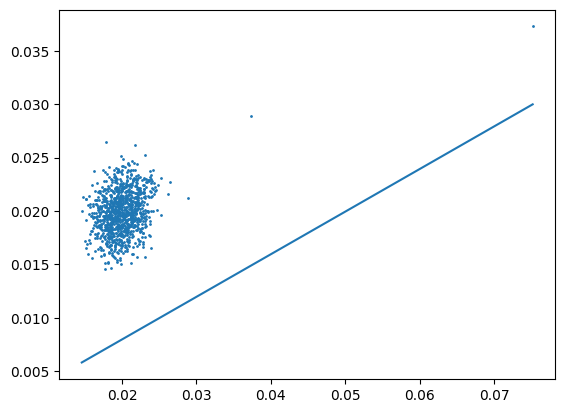

In [26]:
N=1000
theta = 0.5
x = sim(x0, N, theta, 0.13, mu)
mu_hat = MetricData(M, x).frechet_mean()

Ds = np.array([ M._d(x[j,:], mu_hat) for j in range(1, N) ])

dx = Ds[:-1]; vx = np.var(dx)
dy = Ds[1:]; vy = np.var(dy)

plt.scatter(dx, dy, s=1)

theta_hat = np.correlate(dx,dy)
__x = np.linspace(np.min(dx), np.max(dx))
plt.plot(__x, theta_hat*__x)

100%|██████████| 20/20 [00:00<00:00, 63.44it/s]


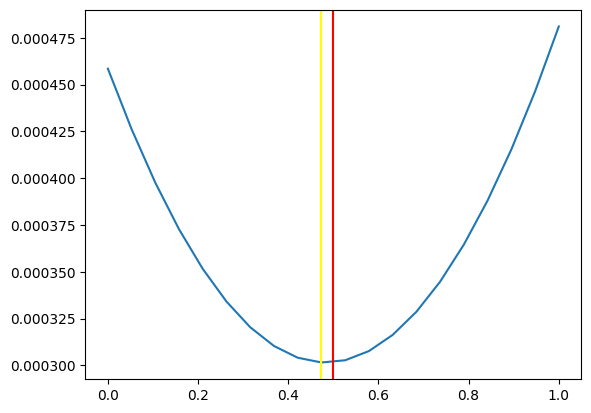

In [4]:
tgrid = np.linspace(0,1,20)

x = sim(x0, N, theta, 0.13, mu)
mu_hat = MetricData(M, x).frechet_mean()

def calc(_theta): return np.array([ M._d(m(x[j-1,:], _theta, mu_hat), x[j,:])**2 for j in range(1, N) ]).mean()
errs = np.array([ calc(tgrid[i]) for i in tqdm(range(tgrid.shape[0])) ])

plt.plot(tgrid, errs)
plt.axvline(theta, color='red')
plt.axvline(tgrid[np.argmin(errs)], color='yellow')

In [60]:
def run_sim():
    tgrid = np.linspace(0,1,100)
    theta = 0.25
    x = sim(300, theta, 0.13, mu)
    mu_hat = MetricData(M, x).frechet_mean()

    def calc(_theta): return np.array([ M._d(m(x[j-1,:], _theta, mu_hat), x[j,:])**2 for j in range(1, x.shape[0]) ]).mean()
    
    mses = np.array([ calc(tgrid[i]) for i in range(tgrid.shape[0]) ])    
    return theta - tgrid[np.argmin(mses)]
    
_res = Parallel(n_jobs=-1, verbose=1)(delayed(run_sim)() for i in range(500))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.7min finished


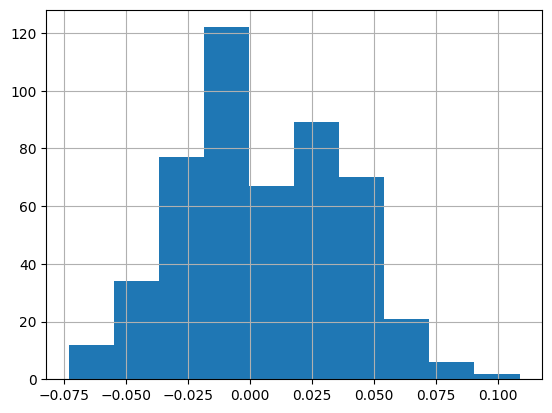

In [61]:
plt.hist(_res); plt.grid()

# Sphere

In [85]:
M = RiemannianManifold(Hypersphere(dim=2))

def add_noise(x, sig):
    v = sig * np.random.normal(size=(M.manifold.dim+1,))
    pvx = v - np.dot(x, v) * x
    return M.manifold.metric.exp(pvx, x)

def m(x, theta, mu):
    # todo: use geodesic from geomstats, will be faster
    return M._frechet_mean(np.array([x, mu]), np.array([theta, 1-theta]))
    
def sim(N, theta, sig, mu):
    x = np.zeros((N,M.manifold.dim+1)) + mu
    for t in range(1,N):
        x[t,:] = add_noise(m(x[t-1,:], theta, mu), sig)
    return x
        
N = 100
theta = -0.4
mu = np.array([np.cos(np.pi/4),np.sin(np.pi/4), 0])
# mu = np.array([0,0,1])

x = sim(N, theta, 0.3, mu)
mu_hats = np.zeros((N, 3))
for i in range(5, N):
    mu_hats[i,:] = MetricData(M, x[:i, :]).frechet_mean()


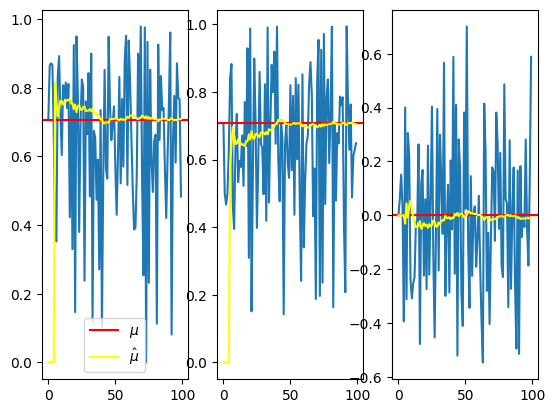

In [86]:
plt.subplot(1,3,1)
plt.plot(x[:,0])
plt.axhline(mu[0], color='red', label=r'$\mu$')
plt.plot(mu_hats[:,0], color='yellow', label=r'$\hat\mu$')
plt.legend()

plt.subplot(1,3,2)
plt.plot(x[:,1])
plt.axhline(mu[1], color='red')
plt.plot(mu_hats[:,1], color='yellow')

plt.subplot(1,3,3)
plt.plot(x[:,2])
plt.axhline(mu[2], color='red')
plt.plot(mu_hats[:,2], color='yellow')



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.1s finished


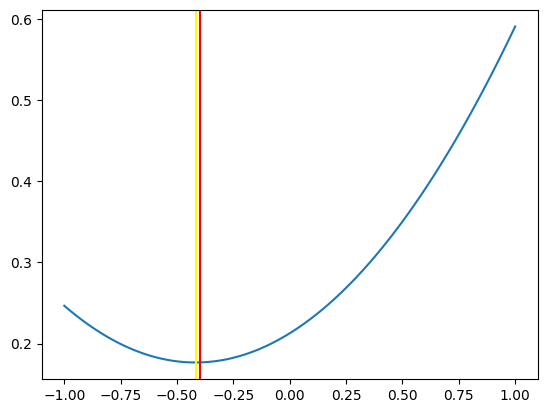

In [14]:

tgrid = np.linspace(-1,1,100)

N = 1000
theta = -0.4
x = sim(N, theta, 0.3, mu)

def calc(_theta): return np.array([ M._d(m(x[j-1,:], _theta, mu_hat), x[j,:])**2 for j in range(1, N) ]).mean()
errs = Parallel(n_jobs=-1, verbose=1)(delayed(calc)(tgrid[i]) for i in range(tgrid.shape[0])) # np.array([ calc(tgrid[i]) for i in tqdm(range(tgrid.shape[0])) ])
errs = np.array(errs)


plt.plot(tgrid, errs)
plt.axvline(theta, color='red')
plt.axvline(tgrid[np.argmin(errs)], color='yellow')

In [17]:
def run_sim(N):
    tgrid = np.linspace(0,1,100)

    theta = 0.25
    x = sim(N, theta, 0.13, mu)
    mu_hat = MetricData(M, x).frechet_mean()

    def calc(_theta): return np.array([ M._d(m(x[j-1,:], _theta, mu_hat), x[j,:])**2 for j in range(1, x.shape[0]) ]).mean()
    
    mses = np.array([ calc(tgrid[i]) for i in range(tgrid.shape[0]) ])    
    return theta - tgrid[np.argmin(mses)]
    

Ns = [50, 100, 200, 400, 800, 1000]
Nsims = 200
all_res = np.zeros((len(Ns), Nsims))
for (i, N) in enumerate(Ns):
    all_res[i, :] = Parallel(n_jobs=-1, verbose=1)(delayed(run_sim)(N) for _ in range(Nsims))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   56.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elap

KeyboardInterrupt: 

In [69]:
np.save('./sphere_ar1.npy', all_res)

<AxesSubplot: xlabel='$\\theta - \\hat\\theta$', ylabel='Density'>

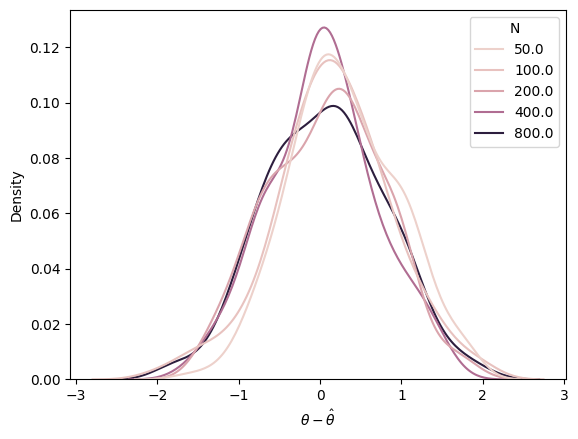

In [112]:
import pandas as pd
import seaborn as sns

lab = r'$\theta - \hat\theta$'
Ns=np.concatenate(np.array([np.repeat([N], Nsims) for N in Ns[:-1]]))
df = pd.DataFrame(data=np.c_[
    np.sqrt(Ns)*np.concatenate(all_res[:-1,:]),
    Ns
], columns=[lab, 'N'])

sns.kdeplot(df, x=lab, hue='N')

<AxesSubplot: xlabel='$\\sqrt{N}(\\theta - \\hat\\theta)$', ylabel='Density'>

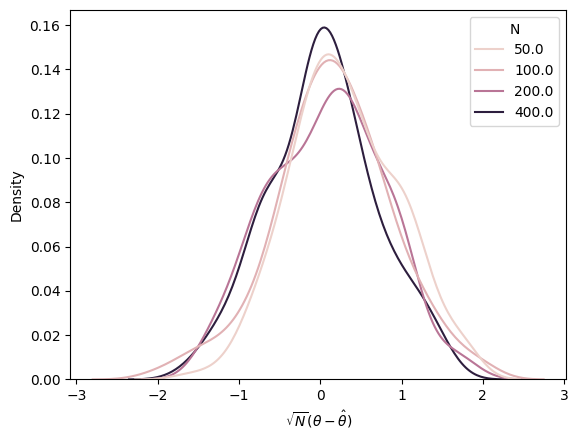

In [81]:
import pandas as pd
import seaborn as sns

lab = r'$\sqrt{N}(\theta - \hat\theta)$'
Ncol = np.concatenate(np.array([np.repeat([N], Nsims) for N in Ns[:-2]]))
df = pd.DataFrame(data=np.c_[
    np.sqrt(Ncol) * np.concatenate(all_res[:-2,:]),
    Ncol
], columns=[lab, 'N'])

sns.kdeplot(df, x=lab, hue='N')

# R with multiplicative noise

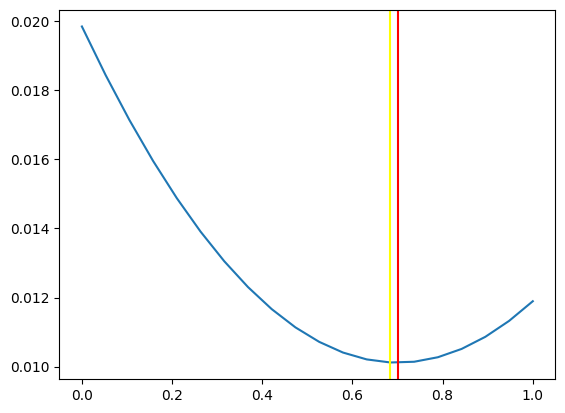

In [213]:
def foo():
    def m(x, theta, mu):
        return theta * x + (1-theta)*mu

    def sim(theta, sig, mu):
        x = np.zeros(N) + mu
        for i in range(1,N):
            x[i] = m(x[i-1], theta, mu) + sig*np.random.randn()
        return x

    def sim_mul(theta, sig, mu):
        x = np.zeros(N) + mu
        for i in range(1,N):
            x[i] = (1 + sig*np.random.randn()) * m(x[i-1], theta, mu)
        return x

    theta = 0.7
    mu = 1.5
    N = 1000
    x = sim(theta, .1, mu)
    mu_hat = x.mean()

    tgrid = np.linspace(0, 1, 20)
    errs = np.zeros_like(tgrid)
    for i in range(tgrid.shape[0]):
        errs[i] = np.array([ (m(x[j-1], tgrid[i], mu_hat) - x[j])**2 for j in range(1, N) ]).mean()

    plt.plot(tgrid, errs)
    plt.axvline(theta, color='red')
    plt.axvline(tgrid[np.argmin(errs)], color='yellow')
    # plt.plot(x)
    
foo()

# Contraction

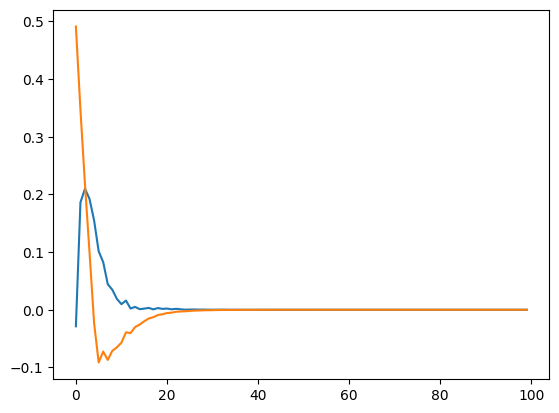

In [428]:
M = RiemannianManifold(Hypersphere(dim=2))

def add_noise(x, sig):
    v = sig * np.random.normal(size=(M.manifold.dim+1,))
    pvx = v - np.dot(x, v) * x
    return M.manifold.metric.exp(pvx, x)


def add_noise2(x, y, sig):
    v = sig * np.random.normal(size=(M.manifold.dim+1,))
    pvx = v - np.dot(x, v) * x
    pvy = M.manifold.metric.parallel_transport(pvx, x, end_point=y)
    return (M.manifold.metric.exp(pvx, x), M.manifold.metric.exp(pvy, y))
    
def m(x, theta, mu):
    return M._frechet_mean(np.array([x, mu]), np.array([theta, 1-theta]))
    
def sim(x0, y0, N, theta, sig, mu):
    x = np.zeros((N,M.manifold.dim+1)) + x0
    y = np.zeros((N,M.manifold.dim+1)) + y0

    for t in range(1,N):
        xt = m(x[t-1,:], theta, mu)
        yt = m(y[t-1,:], theta, mu)
        xt, yt = add_noise2(xt, yt, sig)
        x[t,:] = xt
        y[t,:] = yt
    return x, y
        
N = 100
theta = 0.8

# mu = add_noise(np.array([np.cos(np.pi/2),np.sin(np.pi/2)]), 1)
# x0 = add_noise(mu, 1)
# y0 = add_noise(mu, 1)

# mu = add_noise(np.array([0, 1]), 1)
# x0 = np.array([np.cos(np.pi/4),np.sin(np.pi/4)])
# y0 = np.array([np.cos(-np.pi/4),np.sin(-np.pi/4)])

mu = add_noise(np.array([0, 0, 1]), 1)
x0 = add_noise(np.array([0, 1, 0]), 1)
y0 = add_noise(np.array([0, -1, 0]), 1)


x,y = sim(x0, y0, N, theta, 0.1, mu)
mu_hat = MetricData(M, x).frechet_mean()

# plt.axhline(mu[0])
# plt.plot(x[:,0], label="x0")
# plt.plot(y[:,0], label="y0")

# plt.axhline(mu[1])
# plt.plot(x[:,1], label="x1")
# plt.plot(y[:,1], label="y1")
# plt.legend()

# plt.axhline(mu[2])
# plt.plot(x[:,2])
# plt.plot(y[:,2])

# tx = r2_to_angle(x)
# ty = r2_to_angle(y)

# plt.axhline(np.pi/2)

# plt.plot(tx-ty)

plt.plot(np.sign(x[:,0]-y[:,0]) * np.log1p(np.abs(x[:,0]-y[:,0])))
plt.plot(np.sign(x[:,1]-y[:,1]) * np.log1p(np.abs(x[:,1]-y[:,1])))


0.0
0.22286650766561977


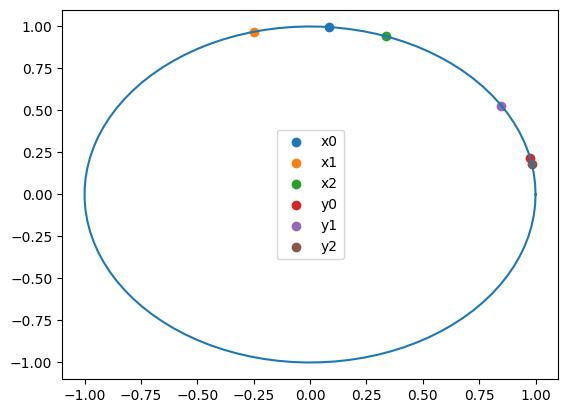

In [419]:

# v = sig * np.random.normal(size=(M.manifold.dim+1,))
# pvx = v - np.dot(x0, v) * x0
# pvy = v - np.dot(y0, v) * y0
# pvy /= np.linalg.norm(pvy)
# pvy = M.manifold.metric.parallel_transport(pvx, x0, end_point=y0)
# plt.plot([x0[0], x0[0] + pvx[0]], [x0[1], x0[1] + pvx[1]])
# plt.plot([y0[0], y0[0] + pvy[0]], [y0[1], y0[1] + pvy[1]])
# x1, y1 = (M.manifold.metric.exp(pvx, x0), M.manifold.metric.exp(pvy, y0))

sig = 0.1
x0 = add_noise(np.array([np.cos(np.pi/3),np.sin(np.pi/3)]), 1)
y0 = add_noise(np.array([np.cos(-np.pi/4),np.sin(-np.pi/4)]), 1)
x1,y1 = add_noise2(x0,y0,1)
print(M.d(x0, y0)- M.d(x1, y1))
x2,y2 = add_noise2(x1,y1,1)
print(M.d(x0, y0)- M.d(x2, y2))

plt.scatter([x0[0]], [x0[1]], label='x0')
plt.scatter([x1[0]], [x1[1]], label='x1')
plt.scatter([x2[0]], [x2[1]], label='x2')
plt.scatter([y0[0]], [y0[1]], label='y0')
plt.scatter([y1[0]], [y1[1]], label='y1')
plt.scatter([y2[0]], [y2[1]], label='y2')
plt.legend()
ts = np.linspace(0, 2*np.pi,100)

plt.plot(np.cos(ts), np.sin(ts))





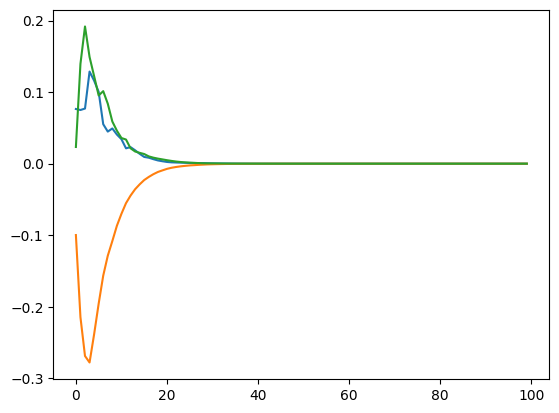

In [473]:
M = CorrFrobenius(3)

def add_noise2(Mu1, Mu2, sig):
    d = Mu1.shape[0]
    Z = np.random.normal(size=(d,d))/4
    Z = Z + Z.T
    Z[np.diag_indices(d)] = np.random.normal(d)
    A1 = Mu1 + sig * Z
    A2 = Mu2 + sig * Z
    return nearcorr(A1, tol=[1e-8,1e-8]), nearcorr(A2, tol=[1e-8,1e-8])


def add_noise(Mu, sig):
    d = Mu.shape[0]
    Z = np.random.normal(size=(d,d))/4
    Z = Z + Z.T
    Z[np.diag_indices(d)] = np.random.normal(d)
    A = Mu + sig * Z
    return nearcorr(A, tol=[1e-8,1e-8])

def m(x, theta, mu):
    return M._frechet_mean(np.array([x, mu]), np.array([theta, 1-theta]))


def sim(x0, y0, N, theta, sig, mu):
    x = np.zeros((N,M.dim,M.dim)) + x0
    y = np.zeros((N,M.dim,M.dim)) + y0
    for t in range(1,N):
        xt, yt = add_noise2(m(x[t-1,:], theta, mu), m(y[t-1,:], theta, mu), sig)
        x[t,:,:] = xt
        y[t,:,:] = yt
    return x, y
        
N = 100
mu = np.array([
    [    1, -0.5,    0],
    [ -0.5,    1, -0.5],
    [    0, -0.5,    1]
])
evals_mu = np.linalg.eigvals(mu)

x0 = add_noise(mu, 1)
y0 = add_noise(mu, 1)

theta = 0.8
x,y = sim(x0, y0, N, theta, 0.1, mu)

xevals = np.zeros((N, M.dim))
yevals = np.zeros((N, M.dim))
for i in range(N):
    xevals[i,:] = np.sort(np.linalg.eigvals(x[i,:,:]))
    yevals[i,:] = np.sort(np.linalg.eigvals(y[i,:,:]))
plt.plot(np.arange(N), xevals[:,0]-yevals[:,0])
plt.plot(np.arange(N), xevals[:,1]-yevals[:,1])
plt.plot(np.arange(N), xevals[:,2]-yevals[:,2])



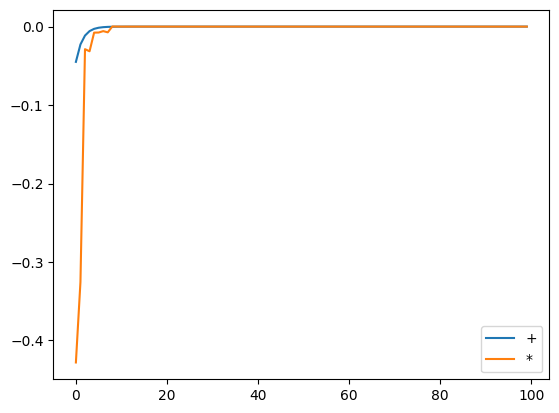

In [125]:
def m(x, theta, mu):
    return theta * x + (1-theta)*mu

def sim(theta, sig, mu):
    x = np.zeros(N) + np.random.randn()
    y = np.zeros(N) + np.random.randn()
    for i in range(1,N):
        eps = sig*np.random.randn()
        x[i] = m(x[i-1], theta, mu) + eps        
        y[i] = m(y[i-1], theta, mu) + eps

    return x, y

theta = 0.5
mu = 1.5
N = 100
x, y = sim(theta, 1, mu)


# x_tp1 - y_tp1 = theta(x_t - y_t) = theta^{t+1}(x_0 - y_0)


plt.plot(np.sign(x-y)*np.log1p(np.abs(x-y)), label='+')
plt.plot(np.sign(xx-yy)*np.log1p(np.abs(xx-yy)), label='*')
plt.legend()
# plt.plot(x)
# plt.plot(y)

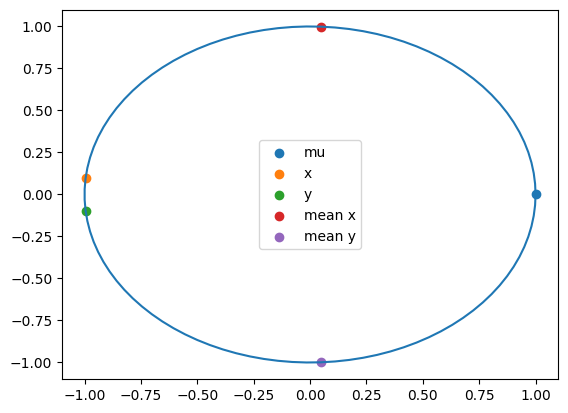

In [176]:

mu = np.array([np.cos(0),np.sin(0)])
x = np.array([np.cos(np.pi -0.1),np.sin(np.pi -0.1)])
y = np.array([np.cos(np.pi +0.1),np.sin(np.pi +0.1)])
sx = m(mu, 0.5, x)
sy = m(mu, 0.5, y)
ts = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ts), np.sin(ts))
plt.scatter([mu[0]], [mu[1]], label='mu')
plt.scatter([x[0]], [x[1]], label='x')
plt.scatter([y[0]], [y[1]], label='y')
plt.scatter([sx[0]], [sx[1]], label='mean x')
plt.scatter([sy[0]], [sy[1]], label='mean y')
plt.legend()

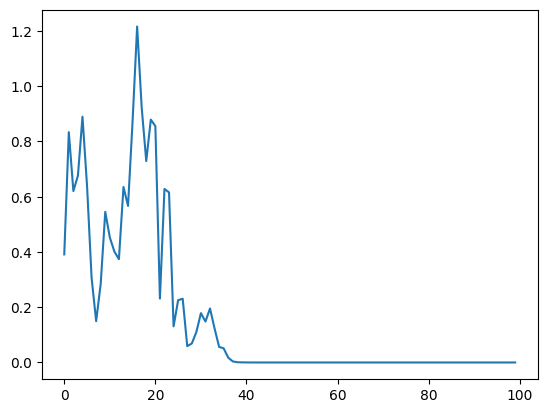

In [166]:

M = RiemannianManifold(Hypersphere(dim=1))

def add_noise(x, sig, eps):
    v = sig * eps
    pv = v - M.manifold.metric.inner_product(x, x, v) * x
    return M.manifold.metric.exp(pv, x)
    
def m(x, theta, mu):
    return M._frechet_mean(np.array([x, mu]), np.array([theta, 1-theta]))
    
    
# thetas = np.linspace(0, 1, 100)
# _sthetas = np.zeros(100)
# for i in range(100):
#     mu = np.array([np.cos(0),np.sin(0)])
#     nu = np.array([np.cos(np.pi),np.sin(np.pi)])
#     s = m(mu, thetas[i], nu)
#     _sthetas[i] = r2_to_angle(s.reshape(1,-1))

# plt.plot(thetas, _sthetas)


mu = np.array([np.cos(0),np.sin(0)])
x = np.array([np.cos(np.pi -0.1),np.sin(np.pi -0.1)])
y = np.array([np.cos(np.pi +0.1),np.sin(np.pi +0.1)])
sx = m(mu, 0.5, x)
sy = m(mu, 0.5, y)
ts = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ts), np.sin(ts))
plt.scatter([mu[0]], [mu[1]], label='mu')
plt.scatter([x[0]], [x[1]], label='x')
plt.scatter([y[0]], [y[1]], label='y')
plt.scatter([sx[0]], [sx[1]], label='mean x')
plt.scatter([sy[0]], [sy[1]], label='mean y')
plt.legend()

mu = np.array([np.cos(0),np.sin(0)])
nu1 = np.array([np.cos(np.pi - 0.1),np.sin(np.pi - 0.1)])
nu2 = np.array([np.cos(np.pi + 0.1),np.sin(np.pi + 0.1)])
ds = np.zeros(100)
for i in range(ds.shape[0]):
    eps = np.random.randn()
    nu1 = add_noise(m(nu1, 0.7, mu), 1, eps)
    nu2 = add_noise(m(nu2, 0.7, mu), 1, eps)
    ds[i] = M.d(nu1,nu2)
plt.plot(ds)

In [ ]:
C = Region where you get closer = 
    { dist(interp(x, mu), interp(y, mu)) < theta d(x, y) }

At some point I'm in C

And P(escaping C) -> 0


